<a href="https://colab.research.google.com/github/LuckerZOfficiaL/A-Contrastive-Learning-Approach-for-Finger-Photo-Identification/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install import-ipynb
import import_ipynb
from google.colab import drive
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np
import os
import random
import cv2
import json
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
import torchvision.models as models
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

drive_path = '/content/drive'
drive.mount(drive_path)

%cd /content/drive/MyDrive/Sapienza/Y1/Biometric Systems/Shared Project Folder/Code
from Architecture import ResnetClassifier
%cd /content/drive/MyDrive/Sapienza/Y1/Biometric Systems/Shared Project Folder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.6 MB/s eta 0:00:00
Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1fz0aq2n-SyUbVYiAvJLNUhWeDGqsiVmb/Sapienza/Y1/Biometric Systems/Shared Project Folder/Code
importing Jupyter notebook from Architecture.ipynb
/content/drive/.shortcut-targets-by-id/1fz0aq2n-SyUbVYiAvJLNUhWeDGqsiVmb/Sapienza/Y1/Biometric Systems/Shared Project Folder


#Galleries for Training and Testing

In [ ]:
train_root_path = './Datasets/5. Thresholded-Then-Thinned'
train_items = os.listdir(train_root_path)

test_root_path = './Datasets/5. Thresholded-Then-Thinned-Test'
test_items = os.listdir(test_root_path)

device = "cuda"
len(train_items), len(test_items)

(832, 192)

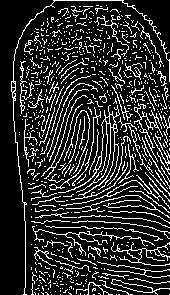

(295, 170)


In [ ]:
img = cv2.imread(train_root_path+"/"+train_items[0], cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)

print(img.shape)

In [ ]:
def create_galleries(folder_path, items, num_eqs_to_have=3, num_others=30, galleries_per_anchor=2):
  #items = os.listdir(test_folder_path)
  test_id_list = []
  test_imgs = []

  for item in items:
      image_path = os.path.join(folder_path, item)
      image = Image.open(image_path).convert("L")
      image = np.array(image)
      image = torch.tensor(image)
      test_imgs.append(image)
      finger_id = int(item.split("_")[0]) * int(item.split("_")[2]) - 1
      test_id_list.append(finger_id)


  test_imgs = torch.stack(test_imgs)
  test_imgs = test_imgs.unsqueeze(1)
  test_ids = torch.tensor(test_id_list)

  possible_anchors = [] # this contains pairs (finger ID, # photos of the same finger ID)
  for i in range(128):
    num_equivalents = torch.where(test_ids == i)[0].size()[0]
    if  num_equivalents > 3: # let's say an image qualifies as anchor if it has at least 3 other equivalents
        possible_anchors.append((i, num_equivalents))

  galleries = []
  for idx, _ in possible_anchors:
    for _ in range(galleries_per_anchor): # we create multiple galleries with each anchor
      initial_gallery = test_imgs[torch.where(test_ids == idx)[0][:num_eqs_to_have], :, :, :] # initialize the gallery with the anchor and some of its equals

      other_test_images = test_imgs[torch.where(test_ids != idx)[0][:], :, :, :]
      others_random_indices = torch.randperm(other_test_images.size(0))[:num_others]
      others_gallery = other_test_images[others_random_indices] # this gallery contains random examples of images of other fingers

      this_gallery = torch.cat((initial_gallery, others_gallery), dim=0)
      galleries.append(this_gallery)

  print(len(galleries), "galleries created")
  return galleries, possible_anchors



def test_for_all_galleries(galleries, num_eqs_to_have, model, logits_from="fc", backbone_in_channels=1):
  correct_count = 0
  wrong_count = 0

  for gallery_idx in range(len(galleries)):
    gallery = galleries[gallery_idx].to("cuda").float()
    if gallery.size()[1] == 1 and backbone_in_channels == 3:
      gallery = gallery.repeat(1,3,1,1) # to duplicate greyscale to 3 channels

    if logits_from == "fc":
      embs = model.forward_logits(gallery)
    elif logits_from == "projector":
      embs = model.forward_projector(gallery)
    else:
      embs = model.forward_backbone(gallery)

    min_dist = float("inf")
    min_dist_idx = None

    for i in range(1, embs.size()[0]):
      this_dist = torch.norm(embs[0] - embs[i]).item()
      if this_dist < min_dist:
        min_dist = this_dist
        min_dist_idx = i

    #print("\nGallery: ", gallery_idx, " eq_num: ", eq_num, " total images: ", embs.size()[0])
    if min_dist_idx < num_eqs_to_have:
      correct_count += 1
      #print("---Correct")
    else:
      wrong_count += 1
      #print("---Wrong")

  return correct_count, wrong_count, correct_count/(correct_count+wrong_count)


def softmax_entropy(logits):
    softmax_probs = F.softmax(logits, dim=1)
    entropy = -torch.mean(torch.sum(softmax_probs * torch.log(softmax_probs + 1e-10), dim=1))
    return entropy

def get_accuracy(logits, true_labels): # true_labels is not one hot, it already contains labels
    predicted_labels = torch.argmax(logits, dim=1)
    correct_predictions = (predicted_labels == true_labels).sum().item()
    accuracy = correct_predictions / len(true_labels)
    return accuracy



def plot_two_lines(train_loss_values, test_loss_values):
        train_loss_values = [val for val in train_epoch_losses_list]
        test_loss_values = [val for val in test_epoch_losses_list]
        x_values = list(range(1, len(train_epoch_losses_list) + 1))
        plt.plot(x_values, train_loss_values, label='Train Loss', marker='o', linestyle='-', color='red')
        plt.plot(x_values, test_loss_values,label='Validation Loss', marker='o', linestyle='-', color='blue')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Loss Per Example')
        plt.title('Mean Training Loss')
        plt.legend()
        plt.show()

In [ ]:
train_galleries, _ = create_galleries(train_root_path, train_items, num_eqs_to_have=2, num_others=40, galleries_per_anchor=3) # num_eqs_to_have=2 means that there is just 1 positive example in the gallery other than the anchor itself
test_galleries, _ = create_galleries(test_root_path, test_items, num_eqs_to_have=3, num_others=40, galleries_per_anchor=3) # num_eqs_to_have=3 means that there are 2 positive example in the gallery other than the anchor itself)

234 galleries created
72 galleries created


In [ ]:
len(train_galleries[0]), len(test_galleries[0])

(42, 43)

# InfoNCE Loss

In [ ]:
! pip install info-nce-pytorch
from info_nce import InfoNCE, info_nce

In [ ]:
infonce_loss = InfoNCE(negative_mode='unpaired')

#### Example Usage

In [ ]:
model = ResnetClassifier(num_classes=100, hidden_size=256, initialize="xavier").to("cuda")

input = train_galleries[0].to("cuda").float() # For example, let's use the first training gallery
output = model.forward_projector(input)
query = output[0].unsqueeze(0)
positive_key = output[1].unsqueeze(0)
negative_keys = output[2:]
print("InfoNCE Loss: ", infonce_loss(query, positive_key, negative_keys))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


InfoNCE Loss:  tensor(2.8082, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
# Into a function
def get_InfoNCE_loss(output):
  query = output[0].unsqueeze(0) # the first embedding in the gallery is always the anchor
  positive_key = output[1].unsqueeze(0) # the first embedding in the gallery is always the positive
  negative_keys = output[2:] # the rest are always negative
  return infonce_loss(query, positive_key, negative_keys)

# Into Training

In [ ]:
model = ResnetClassifier(num_classes=128, hidden_size=256, initialize="xavier")
model.to(torch.device('cuda'))

optimizer = optim.AdamW([
    {'params': model.conv_1to3.parameters(), 'lr': 0.0001},
    {'params': model.pretrained_model.parameters(), 'lr': 0.0001},
    {'params': model.projector.parameters(), 'lr': 0.0001},
    {'params': model.fc.parameters(), 'lr': 0.0001},
], weight_decay=0.0001)

train_with = "projector" # can be one of ["backbone","projector","fc"], indicating which layer to get embeddings from for contrastive training

num_epochs = 40
milestones = [10, 25, 35]
scheduler = MultiStepLR(optimizer, milestones, gamma=0.1)

infonce_loss = InfoNCE(negative_mode='unpaired')

print("Initial Gallery Performance with Backbone: ", test_for_all_galleries(test_galleries, num_eqs_to_have=3, model=model, logits_from="backbone", backbone_in_channels=1))
print("Initial Gallery Performance with Projector: ", test_for_all_galleries(test_galleries, num_eqs_to_have=3, model=model, logits_from="projector", backbone_in_channels=1))
print("Initial Gallery Performance with fc: ", test_for_all_galleries(test_galleries, num_eqs_to_have=3, model=model, logits_from="fc", backbone_in_channels=1))

Initial Gallery Performance with Backbone:  (45, 27, 0.625)
Initial Gallery Performance with Projector:  (50, 22, 0.6944444444444444)
Initial Gallery Performance with fc:  (27, 45, 0.375)


In [ ]:
train_epoch_losses_list = []
test_epoch_losses_list = []


starting_epoch = 0
milestones = [max(0, x - starting_epoch) for x in milestones]
scheduler = MultiStepLR(optimizer, milestones, gamma=0.1)


for epoch in range(starting_epoch, num_epochs):
    # =================== Training ======================
    model.train()
    epoch_loss = 0
    epoch_acc_list = []
    epoch_diff_list = []
    for gallery in tqdm(train_galleries, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch"):

        optimizer.zero_grad()

        input = gallery.to("cuda").float()

        if train_with == "projector":
          output = model.forward_projector(input)
        elif train_with == "backbone":
          output = model.forward_backbone(input)
        else:
          output = model.forward__logits(input)

        loss = get_InfoNCE_loss(output)
        epoch_loss += loss

        loss.backward()
        optimizer.step()

    scheduler.step()
    epoch_loss /= len(train_galleries)
    print(f"Epoch [{epoch+1}/{num_epochs}], Mean Train Loss per Gallery: ", epoch_loss)
    train_epoch_losses_list.append(epoch_loss.item())


    # =================== Validation ======================
    model.eval()
    with torch.no_grad():
      epoch_loss = 0
      epoch_acc_list = []
      epoch_diff_list = []
      for gallery in test_galleries:
          input = gallery.to("cuda").float()

          if train_with == "projector":
            output = model.forward_projector(input)
          elif train_with == "backbone":
            output = model.forward_backbone(input)
          else:
            output = model.forward__logits(input)

          loss = get_InfoNCE_loss(output)
          epoch_loss += loss

      epoch_loss /= len(test_galleries)
      print(f"Epoch [{epoch+1}/{num_epochs}], Mean Test Loss per Gallery: ", epoch_loss)
      test_epoch_losses_list.append(epoch_loss.item())



    # =================== Visualization ======================
    if (epoch+1) % 5 == 0:
        print("Gallery Backbone Train Performance: ", test_for_all_galleries(train_galleries, num_eqs_to_have=2, model=model, logits_from="backbone", backbone_in_channels=3))
        print("Gallery Projector Train Performance: ", test_for_all_galleries(train_galleries, num_eqs_to_have=2, model=model, logits_from="projector", backbone_in_channels=3))
        print("Gallery Backbone Test Performance: ", test_for_all_galleries(test_galleries, num_eqs_to_have=3, model=model, logits_from="backbone", backbone_in_channels=3))
        print("Gallery Projector Test Performance: ", test_for_all_galleries(test_galleries, num_eqs_to_have=3, model=model, logits_from="projector", backbone_in_channels=3))
        print()
        plot_two_lines(train_epoch_losses_list, test_epoch_losses_list)

In [ ]:
print("Gallery Performance with Backbone: ", test_for_all_galleries(train_galleries, num_eqs_to_have=2, model=model, logits_from="backbone", backbone_in_channels=1))
print("Gallery Performance with Projector: ", test_for_all_galleries(train_galleries, num_eqs_to_have=2, model=model, logits_from="projector", backbone_in_channels=1))

print("Gallery Test Performance with Backbone: ", test_for_all_galleries(test_galleries, num_eqs_to_have=3, model=model, logits_from="backbone", backbone_in_channels=1))
print("Gallery Test Performance with Projector: ", test_for_all_galleries(test_galleries, num_eqs_to_have=3, model=model, logits_from="projector", backbone_in_channels=1))

Gallery Performance with Backbone:  (234, 0, 1.0)
 Gallery Performance with Projector:  (234, 0, 1.0)
Gallery Test Performance with Backbone:  (66, 6, 0.9166666666666666)
 Gallery Test Performance with Projector:  (68, 4, 0.9444444444444444)


In [ ]:
path_name = "./Code/Models/resnetSimCLR_512hidden.pth" #############
torch.save(model.state_dict(), path_name)